In [3]:
import torch
import torchvision 

print(torch.__version__)
print(torchvision.__version__)

1.10.0
0.11.1


In [4]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

except:
    print("[INFO] Couldn't fing going_modular or helper_functions")

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

In [6]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [7]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

## 3. Creating an EffNetB2 feature extractor

In [26]:
effnetb2 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# 2. Get EffNetB2 transforms
effnetb2_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 3. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

In [27]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [28]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

In [44]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    model = torchvision.models.efficientnet_b2(pretrained=True).to(device)
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    
    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transform

In [45]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [46]:
from torchinfo import summary

# summary(effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [47]:
from going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [48]:
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2.to(device)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:05<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 12.
Original Traceback (most recent call last):
  File "C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\torch\utils\data\_utils\collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\torch\utils\data\_utils\collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\torch\utils\data\_utils\collate.py", line 54, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\torch\storage.py", line 155, in _new_shared
    return cls._new_using_filename(size)
RuntimeError: falseINTERNAL ASSERT FAILED at "..\\aten\\src\\ATen\\MapAllocator.cpp":135, please report a bug to PyTorch. Couldn't open shared file mapping: <0000025E5B783852>, error code: <1455>


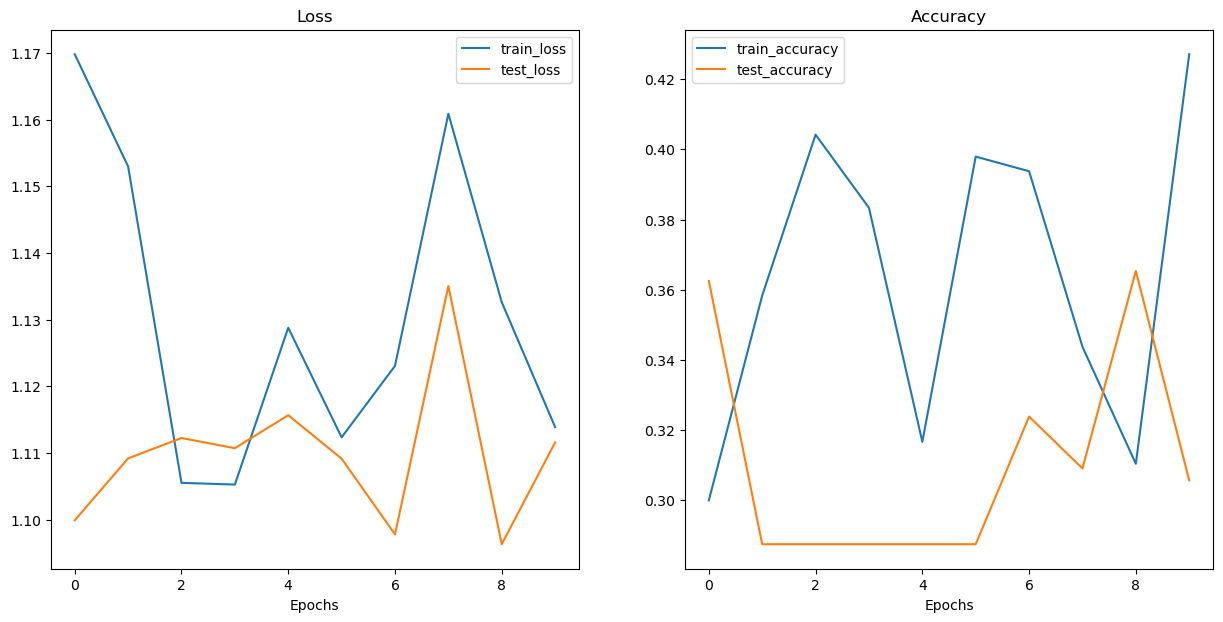

In [34]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [35]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [24]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetb2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetb2 feature extractor model size: 29 MB


In [36]:
# Count number of parameters in EffNetb2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [37]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                 "test_acc": effnetb2_results["test_acc"][-1],
                 "number_of_parameters": effnetb2_total_params,
                 "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 1.111557412147522,
 'test_acc': 0.30568181818181817,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [49]:
def create_vit_model(num_classes:int=3,
                    seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    tranforms = trochvision.transforms()
    model = torchvision.models.vit_b_16(weights=weights)
    
    for param in model.parameters():
        param.requires_grad = False
        
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                         out_features=num_classes))
    
    return model, transforms

In [50]:
vit, vit_tranforms = create_vit_model(num_classes=3,
                                     seed=42

AttributeError: module 'torchvision.models' has no attribute 'ViT_B_16_Weights'